In [1]:
import importlib
import math
import argparse
import sys
import time
import traceback
import json
from pubsub import pub
pub.unsubAll()
import schedula as sh
import numpy as np
import cv2

import VODEvents
from ImgProc import ImgTask
import RangeStats

from video import *

In [2]:
argp = argparse.ArgumentParser(description='VOD review tool')
argp.add_argument('source', nargs='?', default='test.mkv', 
                help='video source path')
argp.add_argument('--skip', type=int, nargs='?', default=190,
                help='start at offset frames into video')
argp.add_argument('-m', '--manual', action='store_false',
                help='turn off autoplay')
argp.add_argument('-d', '--dump', nargs='?', const='dump.mp4', default=None,
                help='dump out debug frame to video file')
params = argp.parse_args('test.mkv'.split(' '))

In [5]:
src = VideoSource.instance
if not src.open(params.source):
    print ('FATAL ERROR: cannot open video')
    exit()
    
DUMP = False
if params.dump is not None:
    DUMP = True
    from ImgProc import VideoWriter
    VideoWriter.path = params.dump
    print('Video writer imported')
    
src.skip_to_frame(params.skip) # skip VOD preamble
# 23-09-15 tricky bot appear: 1440, 2590
# 23-12-24 tricky bot appear: 811, 1433
xdim, ydim, frate, frames_total = src.get_video_params()
depth = src.frame.shape[-1]
print ('Video = %s @ %s fps. %s frames'%(src.frame.shape, frate, frames_total))

show_img = 0
autoplay = params.manual
if not BATCH:
    def breakpoint(timestamp=0, x=0, y=0):
        global autoplay
        autoplay = False
    #pub.subscribe(breakpoint, VODEvents.BOT_APPEAR) # pause at certain events
    #pub.subscribe(breakpoint, VODEvents.KEY_ANY_DOWN) # pause at certain events
else:
    autoplay = True

Video = (1080, 1920, 3) @ 60.0 fps. 2955 frames


In [6]:
pub.subscribe(dbg_event, pub.ALL_TOPICS)
pub.sendMessage(ImgEvents.INIT, 
                pipe= ImgTask.pipe,
                width= xdim,
                height= ydim,
                depth= depth,
                frame_rate= frate,) # initialize all modules

ImgTask.pipe.add_capture(ImgTask.IMG_DEBUG)
ImgTask.pipe.add_capture(VODEvents.EVENT_NODE)

event VSTART / {'pipe': <ImgProc.ImgTask.ImgPipe object at 0x000001F57E5F3E90>, 'width': 1920, 'height': 1080, 'depth': 3, 'frame_rate': 60.0}


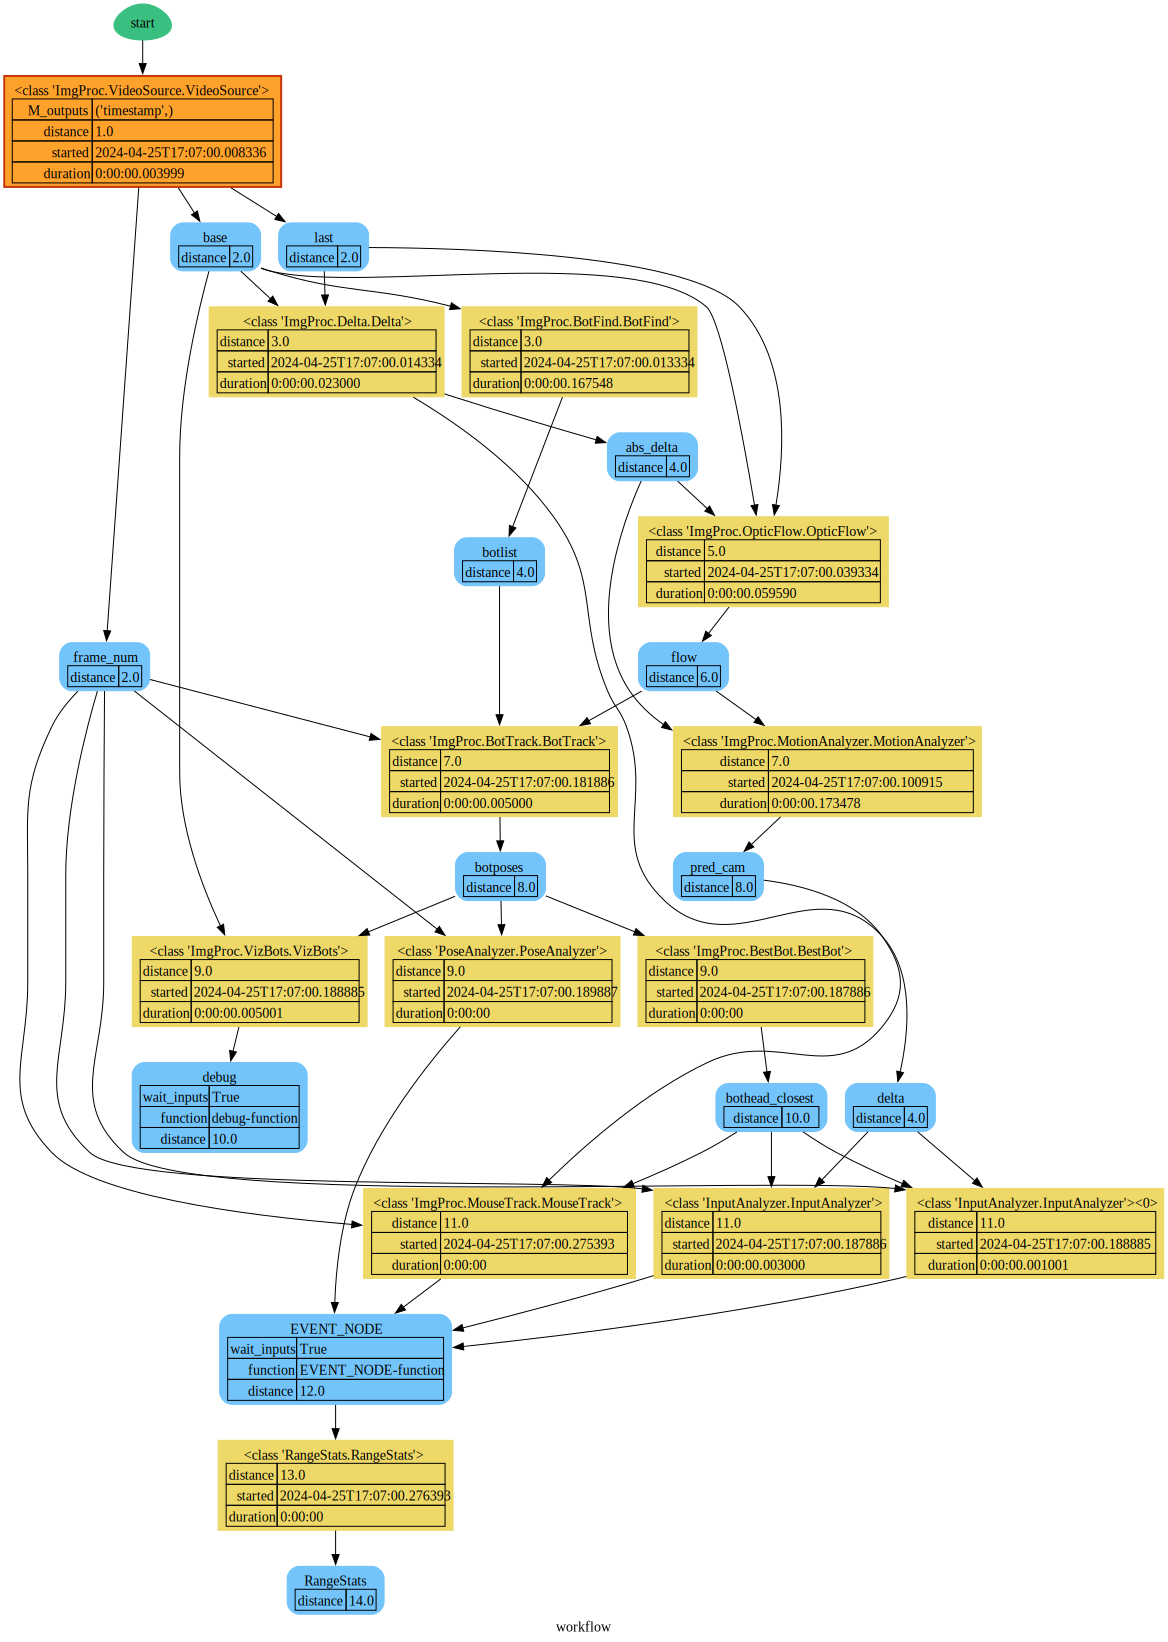

In [38]:
plt = ImgTask.pipe.dsp.plot(view=False, engine='dot', body={'style': 'filled', 'ordering':'out'}, workflow=True)
display(plt)

In [39]:
total=0
for k,v in ImgTask.pipe.dsp.solution.workflow.nodes.items():
    if 'duration' in v:
        dur = v['duration']*1000
        total += dur
        print ('%s : %s'%(k, dur))
print ('total= %s'%(total))

<class 'ImgProc.VideoSource.VideoSource'> : 3.9992332458496094
<class 'ImgProc.VizBots.VizBots'> : 5.001068115234375
<class 'ImgProc.Delta.Delta'> : 23.000001907348633
<class 'ImgProc.BotFind.BotFind'> : 167.54841804504395
<class 'ImgProc.OpticFlow.OpticFlow'> : 59.59033966064453
<class 'ImgProc.MouseTrack.MouseTrack'> : 0.0
<class 'InputAnalyzer.InputAnalyzer'> : 3.000497817993164
<class 'InputAnalyzer.InputAnalyzer'><0> : 1.001119613647461
<class 'PoseAnalyzer.PoseAnalyzer'> : 0.0
<class 'ImgProc.BotTrack.BotTrack'> : 5.000114440917969
<class 'ImgProc.MotionAnalyzer.MotionAnalyzer'> : 173.478364944458
<class 'ImgProc.BestBot.BestBot'> : 0.0
debug : 0.0
EVENT_NODE : 0.0
<class 'RangeStats.RangeStats'> : 0.0
total= 441.6191577911377


In [37]:
print (src.frame_num)

tst = time.time_ns()
outs = [RangeStats.NODE]
outs.append(ImgTask.IMG_DEBUG)
if DUMP:
    outs.append(VideoWriter.WRITER_NODE)
try:
    sol = ImgTask.pipe.run_pipe(ins=None, outs=outs)
except VideoSource.VideoException: # out of frames
    exit()
ten = time.time_ns()
print ('pipe= %3.3fms'%((ten-tst)/1e6))

216
pipe= 271.060ms


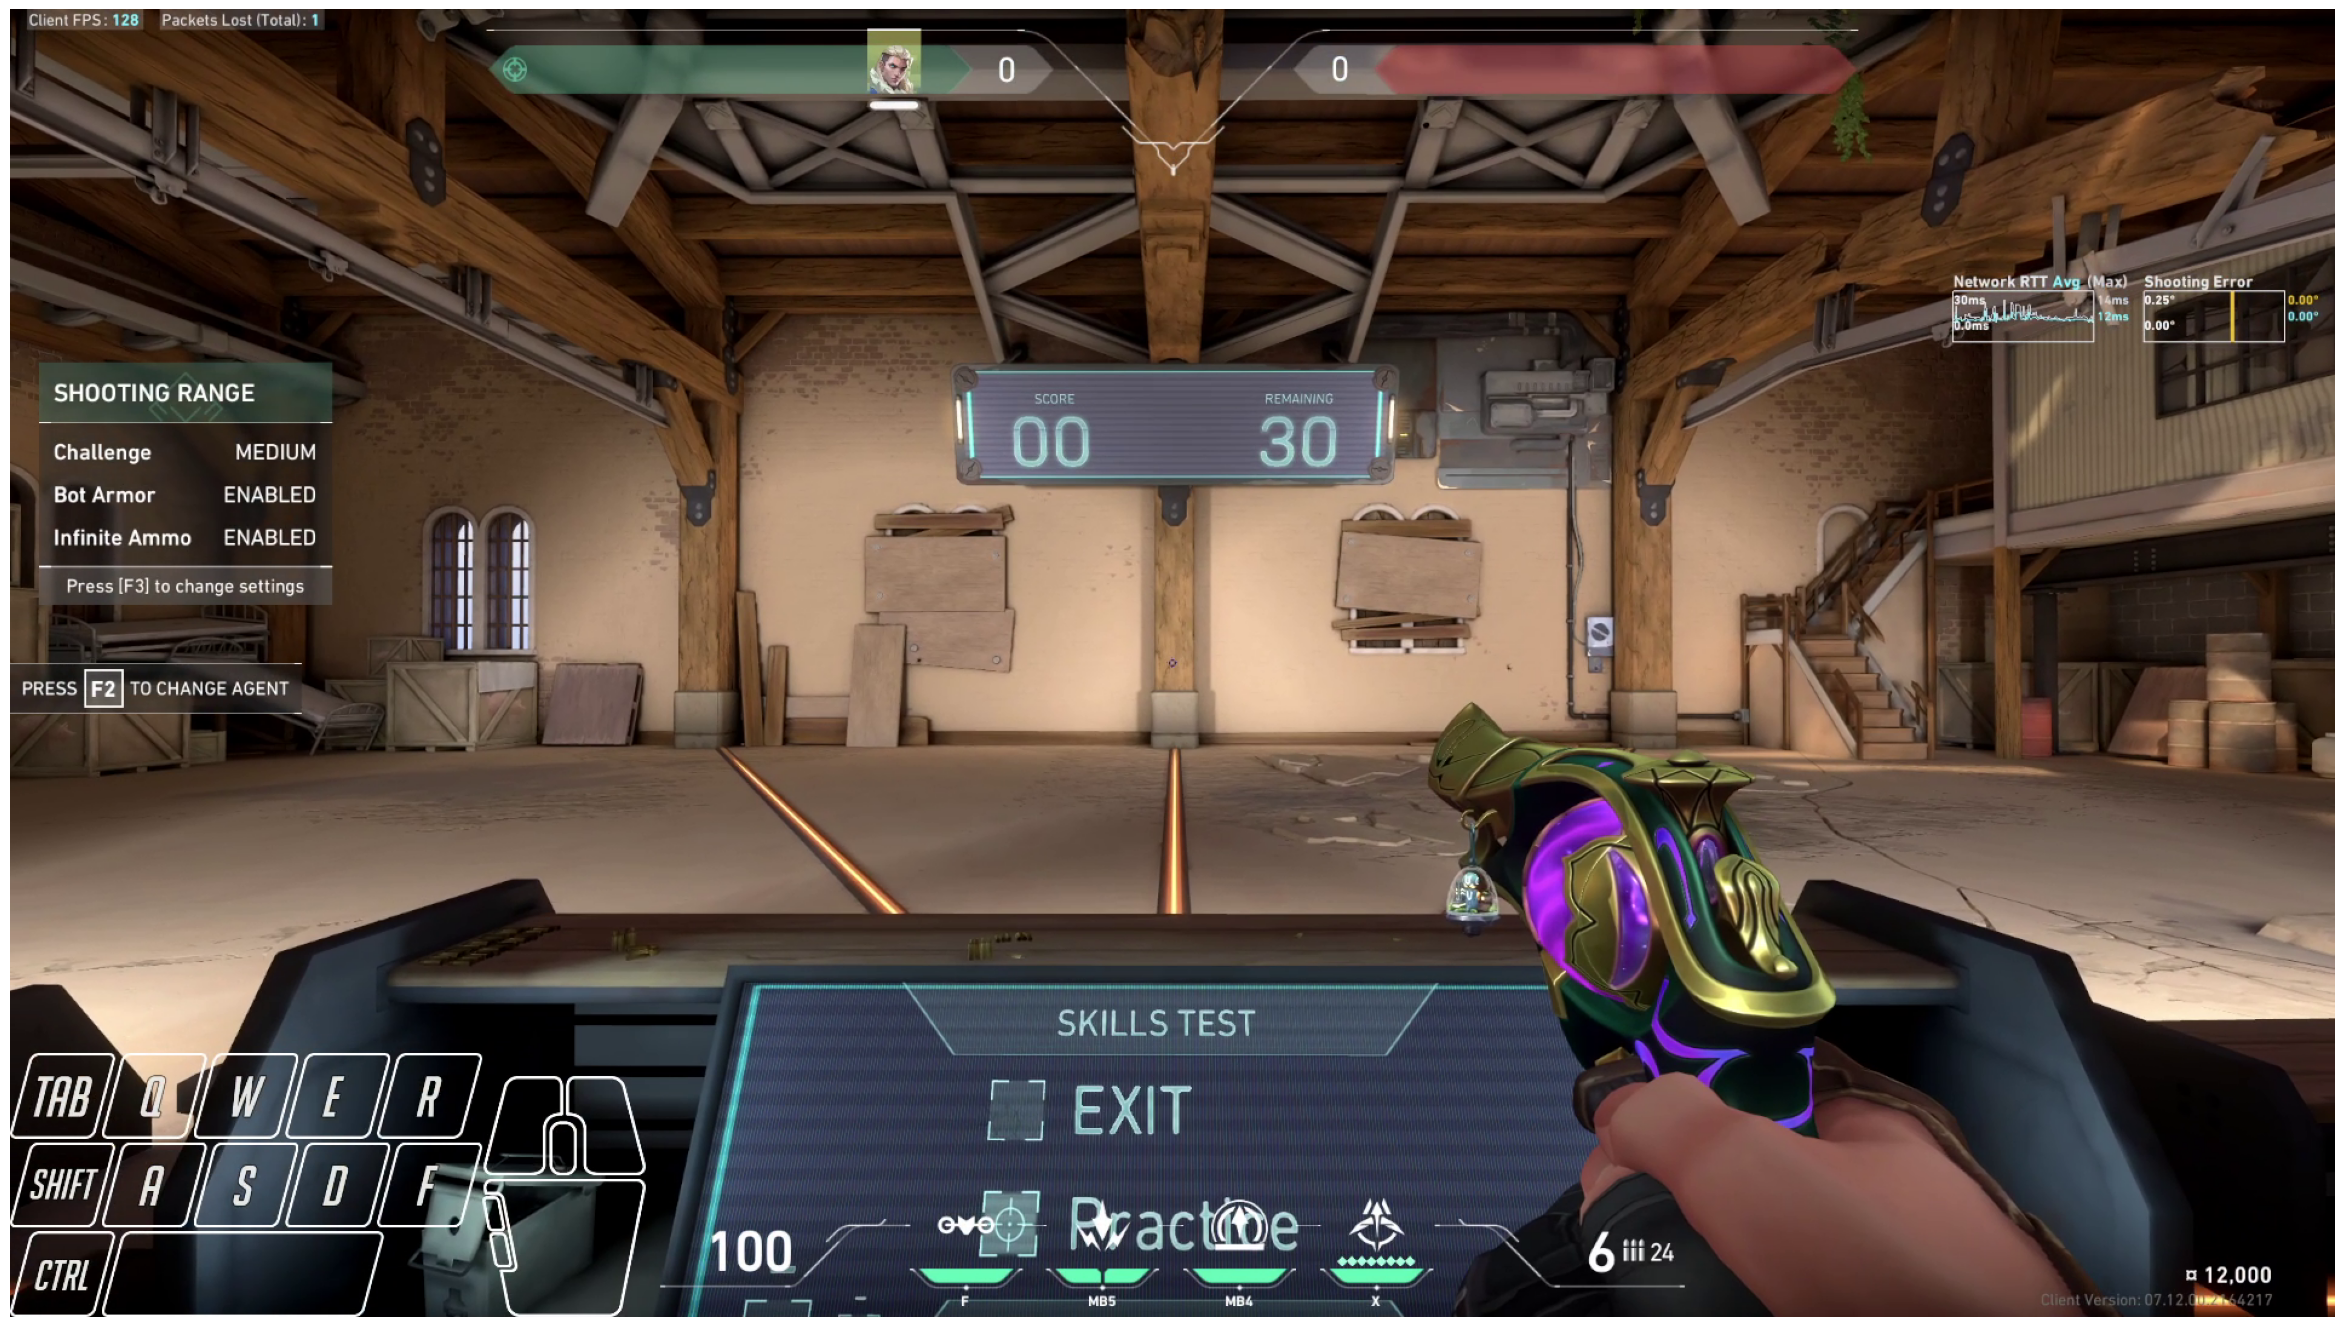

In [11]:
%matplotlib inline

from matplotlib import pyplot as plt

k1 = [*sol['debug']][0]
outimg = sol['debug'][k1]
outimg = cv2.cvtColor(outimg, cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
plt.figure(figsize=(30, 20))
plt.axis('off')
plt.imshow(outimg)
plt.show()

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

k1 = [*sol['debug']][1]
outimg = sol['debug'][k1]
outimg = cv2.cvtColor(outimg, cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
plt.figure(figsize=(30, 20))
plt.axis('off')
plt.imshow(outimg)
plt.show()

In [ ]:
aug_shape = (frame.shape[0], frame.shape[0], 2)
y = np.zeros(aug_shape)
y.shape

In [ ]:
dsp = sh.Dispatcher(name='test', raises=True)
class CException(Exception):
    pass
    
def my_function(a,b):
    c=a+b
    d=a-b
    time.sleep(0.5)
    #raise CException()
    return c,d

def hole(a):
    print (a)
    return 1

def hole2(a):
    print(a)

def collate(kwargs):
    return kwargs

dsp.add_data(data_id='g', wait_inputs=True, function=collate)
dsp.add_function(function=my_function, inputs=['a1', 'b1'],
                 outputs=['c', 'd'])
dsp.add_function(function=lambda x,y: x*10+y*100, inputs=['c', 'd'],
                 outputs=['e'])
dsp.add_function(function=lambda x,y: x*10+y*100, inputs=['a1', 'b1'],
                 outputs=['f'])
dsp.add_function(function=hole, inputs=['f'],
                 outputs=['g'])
dsp.add_function(function=hole2, inputs=['e'],
                 outputs=['g'])
dsp.add_function(function=collate, inputs=['g'],
                 outputs=['h'])
#dsp.add_data(data_id='g')

In [ ]:
outs = ['g']
sol = dsp.dispatch({'a1': np.array([[5,2,3,1],[1,2,3,4]]), 'b1': 3}, outputs=outs, executor='async')
print (sol)
try:
    sol2 = sol.result()
except Exception as e:
    print ('exception')
    xx=e
print (sol2)
res = {k:sol[k] for k in outs}
print (res)
print (res['g'])

In [ ]:
# Click on the graph to see the model.
x = dsp.plot(view=False, engine='dot', body={'style': 'filled'}, workflow=True)

In [ ]:
display(x)

In [ ]:
print(vars(xx))

In [ ]:
isinstance(res['g'], dict)

In [ ]:
list(res['g'].values())